# Holt-Winter Method (Triple Exponential Smoothing)
Exponential smoothing is a rule of thumb technique for smoothing time series data using the exponential window function. Whereas in the simple moving average the past observations are weighted equally, exponential functions are used to assign **exponentially decreasing weights over time**. It is an easily learned and easily applied procedure for making some determination based on prior assumptions by the user, such as seasonality. Exponential smoothing is used for analysis of time-series data.


**Triple exponential smoothing** applies exponential smoothing three times, which is commonly used when there are three high frequency signals to be removed from a time series under study. There are different types of seasonality: 'multiplicative' and 'additive' in nature, much like addition and multiplication are basic operations in mathematics.

Suppose we have a sequence of observations $x_t$, beginning at time t = 0 with a cycle of seasonal change of length L.

The method calculates a trend line for the data as well as seasonal indices that weight the values in the trend line based on where that time point falls in the cycle of length L.

The output of the algorithm is again written as $F_{t+m}$, an estimate of the value of x at time t+m, m>0 based on the raw data up to time t. Triple exponential smoothing with multiplicative seasonality is given by the formulas:


$$S_t  =  \alpha \frac{x_t}{c_{t-L}} + (1-\alpha)(S_{t-1}+b_{t-1})$$
$$b_t  =  \beta (S_t - S_{t-1}) + (1 - \beta)b_{t-1} $$
$$c_t  =  \gamma \frac{x_t}{S_t} + (1 - \gamma) c_{t-L}$$ 
$$F_{t+m}  =   (S_t + m b_t) c_{t-L+m} $$

where

 - *x* is the observation
 - *S* is the smoothed observation
 - *b* is the trend factor
 - *c* is the seasonal index
 - *F* is the forecast at m periods ahead
 - *t* is an index denoting a time period
 - *α* is the data smoothing factor, 0 < α < 1
 - *β* is the trend smoothing factor, 0 < β < 1
 - *γ* is the seasonal change smoothing factor, 0 < γ < 1.


The following code will go through the procedure of implementing a **Triple Exponential Smoothing**.

# Importing the Dataset

In [76]:
#Importing the needed libraries
import csv
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [77]:
#Importing the data
df = pd.read_csv('data.csv', parse_dates=['Datetime'], index_col='Datetime')

#Setting the granularity of data to 5min
df.index.freq = '5T'

#Printing head
print(df.head())

                        Count
Datetime                     
2018-12-20 16:25:00  392263.6
2018-12-20 16:30:00  440813.4
2018-12-20 16:35:00  489368.4
2018-12-20 16:40:00  487068.0
2018-12-20 16:45:00  484785.0


As we can see the dataset is composed of two columns: *Datetime* - which indicates the time and date for each 5min component, and a *Count* value which sums up the number of requests in a 5 min interval.

# Data Visualisation

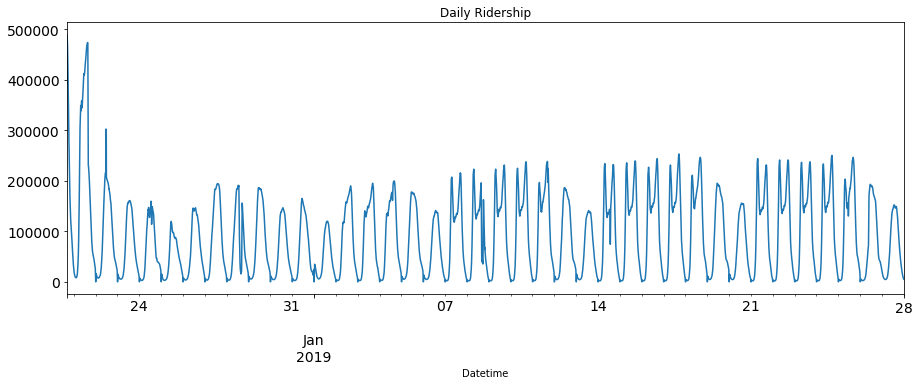

In [78]:
#Visualising the data
df.Count.plot(figsize=(15,5), title= 'Daily Ridership', fontsize=14)
plt.show()

As we can see in the graph, the dataset includes a couple of **very anomalous days** (21-23 december).
To insure the fact that our algorithm trains on good data, and actually learns from a right pattern of data, we will cut out those few days. 

If you are wondering what happens if you include the whole data set, you can try it out. The result will be an almost good prediction (that follows the pattern) but it will go higher than the expected values (being influienced by the average of those few very high values).

## Data Pre-processing
To determine how exactly to divide the dataset into a training and testing parts, we will count the total number of 5min buckets, and leave the last 20% (common standard) of those for the testing.

In [79]:
#Counting the number of 5min periods composing in the dataset
count = len(df)
print(f"Total number of periods = {str(count)}")

#Calculating the divider point between the training set and testing set
trainend = round(count*0.8)
print(f"The dividing point = {str(trainend)}")

Total number of periods = 11036
The dividing point = 8829


In [80]:
#Dividing the data into a training set and a testing set 
#Because of the first few anomalous days, we don't start the training set at 0, but at 3000
train, test = df.iloc[3000:trainend, 0], df.iloc[trainend+1:, 0]

## Timeseries decomposition

To see if the Holt method is appliable, we can first verify if a trend exists in the data.
Each Time series dataset can be decomposed into it’s componenets which are Trend, Seasonality and Residual.

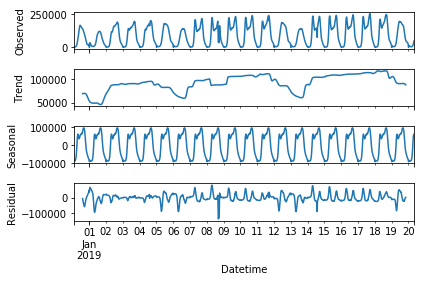

In [81]:
import statsmodels.api as sm
decompfreq = ((24*60)//5)
sm.tsa.seasonal_decompose(train, freq=decompfreq).plot()
result = sm.tsa.stattools.adfuller(train)
plt.show()

As seen in the graph, we can identify a **weekly trend** where more data is gathered during the week, and less during the weekends.

We can also observe the **seasonality** of the data that follows (as expected) a rush-hour pattern with 2 peaks. They are not very proeminent because of the first week of holidays that looks almost Gaussian.

# Holt-Winter Implementation

In this method, we can implement both *additive* and *multiplicative* technique.  The additive method is preferred when the seasonal variations are roughly constant through the series, while the multiplicative method is preferred when the seasonal variations are changing proportional to the level of the series.

Because both methods have exactly the same number of parameters to estimate, we can compare the training RMSE from both models. In this case, the method with multiplicative seasonality fits the data best (this is why we set the **seasonal ='mul'**). This was to be expected, as the time plot shows that the seasonal variation in the data increases as the level of the series increases. 

**α,β,γ** - can be estimated (usually through a trial and error process known as *fitting*) and can be left for the algorithm to estimate or manually set in the *.fit()* method as following:
ExponentialSmoothing.fit(smoothing_level=None, smoothing_slope=None, smoothing_seasonal=None, damping_slope=None, optimized=True, use_boxcox=False, remove_bias=False, use_basinhopping=False, start_params=None, initial_level=None, initial_slope=None, use_brute=True) __[see link for more details](https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.fit.html#statsmodels.tsa.holtwinters.ExponentialSmoothing.fit)__

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:336: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


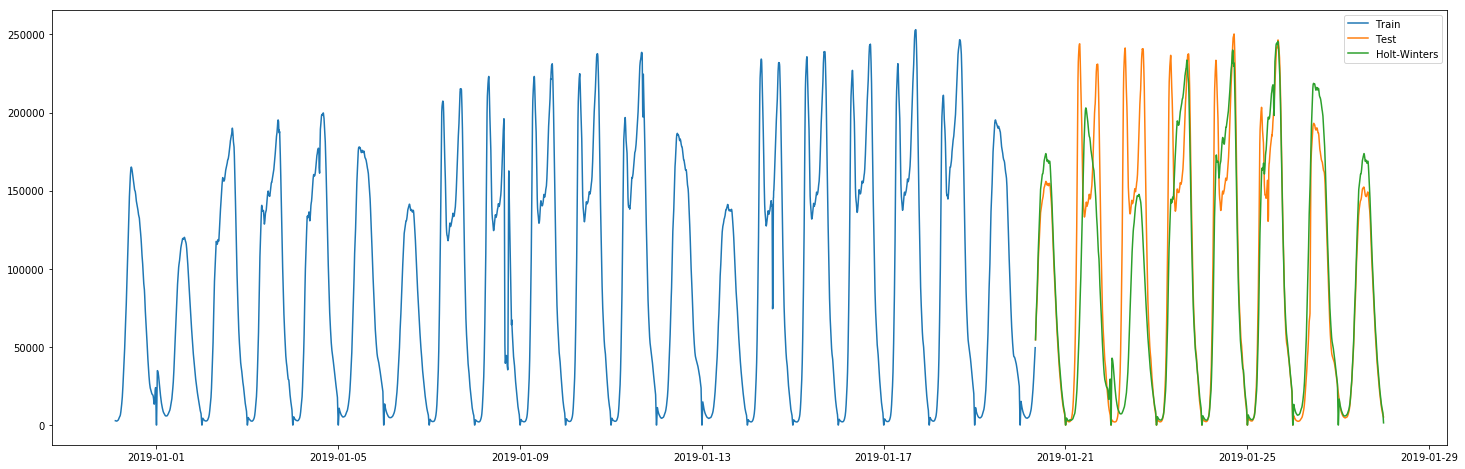

In [82]:
#Calculating the season lenght, which in our case is a week expressed in 5min granularity
seasonl = int(7*24*60/5)

#Implementing the Exponential Smoothing method
model = ExponentialSmoothing(train, seasonal_periods=seasonl, seasonal='mul').fit()
pred = model.predict(start=test.index[0], end=test.index[-1])

#Plotting data
plt.figure(figsize=(25,8))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(pred.index, pred, label='Holt-Winters')
plt.legend(loc='best')

## Error estimation

In [75]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(test, pred))
print(rms)

43863.44580171522


For more details about *Exponential Smoothing* implemented in **statsmodel** Python module, please see the documentation _[here](https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html)_. 